I check whether my formula for the variance-covariance matrix of 
$$y_t = \frac{1}{3} u_t + \frac{2}{3} u_{t-1} + \frac{3}{3} u_{t-2} + \frac{2}{3} u_{t-3} + \frac{1}{3} u_{t-4}$$
with $u_t = \psi u_{t-1} + w_t$ is true with simulated data.

In [11]:
using StatsBase
using Gadfly

In [12]:
function autocov2(ψ, σ2w, Δt)
    p0 = 19*ψ^(abs(Δt))
    p1 = 16*ψ^(abs(Δt-1))+16*ψ^(abs(Δt+1))
    p2 = 10*ψ^(abs(Δt-2))+10*ψ^(abs(Δt+2))
    p3 =  4*ψ^(abs(Δt-3))+ 4*ψ^(abs(Δt+3))
    p4 =    ψ^(abs(Δt-4))+   ψ^(abs(Δt+4))
    return σ2w/(1-ψ^2)*(p0+p1+p2+p3+p4)/9
end

autocov2 (generic function with 1 method)

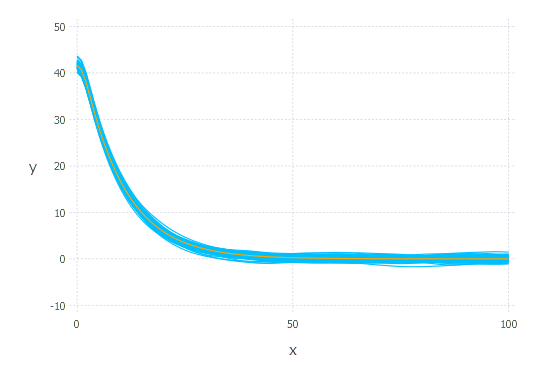

In [31]:
ψ = 0.9
σ2w = 1.

T = 10^5
S = 100


Δt_max=100

autoc = zeros(S, Δt_max+1)

for s=1:S
    u = zeros(T)
    u[1] = sqrt(σ2w/(1-ψ^2))*randn()

    for t=1:T-1
        u[t+1] = ψ*u[t] + sqrt(σ2w)*randn()
    end
    
    z = 1/3*(u[5:end]+2*u[4:end-1]+3*u[3:end-2]+2*u[2:end-3]+u[1:end-4])
    
    autoc[s,:] = autocov(z, 0:Δt_max)
end

plot(
    layer(x=0:Δt_max, y=[autocov2(ψ, σ2w, i) for i=0:Δt_max], Geom.line(), Theme(default_color="orange")),
    [layer(x=0:Δt_max, y=autoc[i, :], Geom.line()) for i=1:S]...
    )

In [22]:
#plot(
#    layer(x=0:50, y=ψ.^(0:50)*σ2w/(1-ψ^2), Geom.line(), Theme(default_color="orange")),
#    layer(x=0:50, y=autocov(u, 0:50), Geom.line())
#    )

## Comparing the performance of different ways to calculate the variance covariance matrix

bottomline: list comprehensions are difficult to beat!

### AR(1) process

In [32]:
T = 300
S = 1000;

In [24]:
@time begin
    for s=1:S 
        M=σ2w/(1-ψ^2)*[ψ^abs(i-j) for i=1:T, j=1:T] 
    end
end

  7.937707 seconds (90.03 M allocations: 2.684 GiB, 1.67% gc time)


In [25]:
@time begin
    Δt = abs.(ones(T,1)*(1:T)' - (1:T)*ones(1,T))
    for s=1:S
        M = σ2w/(1-ψ^2)*ψ.^Δt
    end
end

  8.601227 seconds (34.03 k allocations: 1.345 GiB, 0.53% gc time)


### $w(L)u_t$ where $u_t$ is AR(1)

In [26]:
T = 300
S = 100

100

In [27]:
@time begin
    for s=1:S 
        M=[autocov2(ψ, σ2w, abs(i-j)) for i=1:T, j=1:T] 
    end
end

  8.392686 seconds (9.02 M allocations: 206.869 MiB, 0.15% gc time)


In [28]:
@time begin
    Δt = ones(T,1)*(1:T)' - (1:T)*ones(1,T)
    for s=1:S
        Φ = σ2w/(9*(1-ψ^2))*(
            19*ψ.^(abs.(Δt))+
            16*ψ.^(abs.(Δt-1))+16*ψ.^(abs.(Δt+1))+
            10*ψ.^(abs.(Δt-2))+10*ψ.^(abs.(Δt+2))+
             4*ψ.^(abs.(Δt-3))+ 4*ψ.^(abs.(Δt+3))+
               ψ.^(abs.(Δt-4))+   ψ.^(abs.(Δt+4))
        )
    end
end

  8.665266 seconds (93.07 k allocations: 2.219 GiB, 1.36% gc time)
